In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load

import clean_utils
from importlib import reload


### Load Data

In [2]:
parcels = pd.read_csv('../data/Blue Sky Code and Inputs/SF_Logistic_Data.csv')

In [3]:
allParcels = gpd.read_file('../data/Parcels   Active and Retired/parcels.shp')

In [4]:
sites = gpd.read_file('../data/site_inventory/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp')

In [5]:
tax = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx')

In [6]:
tax15 = pd.read_excel('../data/tax_assessor/2020.7.10_SF_ASR_Secured_Roll_Data_2015-2016.xlsx')

In [7]:
slopes = gpd.read_file('../data/Slopes of 20% Or Greater/geo_export_2dd8ac56-99a0-4a45-ba46-c85a7407e3e5.shp')

In [8]:
census = gpd.read_file('../data/Census 2000_ Tracts for San Francisco (no water)'
                       '/geo_export_4609700a-c230-4617-92b7-4ef34f23f741.shp')

In [9]:
sfneighborhoods = gpd.read_file('../data/SF Find Neighborhoods/geo_export_2ecdf278-8615-4538-9268-0d4992d30e52.shp')

In [10]:
home_prices = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [11]:
home_prices = home_prices[home_prices.City == 'San Francisco']

In [12]:
home_prices = home_prices[['RegionName', '2007-01-31']]

In [13]:
home_prices = home_prices[home_prices.notna().all(axis=1)]

In [14]:
# These codes are the same in both 2007-2008 and 2015-2016
use_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                          sheet_name='Class & Use Code')
neighborhood_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                                   sheet_name='Neigborhood Code')

### Geospatial version of bluesky data

In [15]:
def get_basic_df(cycle):
    if cycle == 4:
        start_year = 2007
    else:
        start_year = 2015
    trainParcels = parcels[(parcels.year >= start_year) & (parcels.year < (start_year + 8))]
    trainY = trainParcels.groupby('MapBlkLot_Master')['Developed'].agg(lambda x: x.ne(0).sum())
    trainX = trainParcels[trainParcels.year == start_year]
    trainDf = pd.merge(trainX.drop('Developed', axis=1), trainY, left_on='MapBlkLot_Master', right_index=True)
    df = clean_utils.transform_bluesky_to_geospatial(trainDf, cycle)
    return df

In [16]:
df4 = get_basic_df(4)

In [17]:
df4.head()

,MapBlkLot_Master,mapblklot,blklot,active,geometry,year,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,...,zp_DensRestMulti,zp_FormBasedMulti,zp_PDRInd,zp_Public,zp_Redev,zp_RH2,zp_RH3_RM1,Developed,CANTID_blklot_backup,CANTID_geometry_backup
0,0001001,0001001,0001001,T,"POLYGON ((-122.42200 37.80848, -122.42208 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,1,0,0,0,0,NaN,NaN
1,0002001,0002001,0002001,T,"POLYGON ((-122.42083 37.80863, -122.42086 37.8...",2007,1,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
2,0004002,0004002,0004002,T,"POLYGON ((-122.41570 37.80833, -122.41576 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
3,0005001,0005001,0005001,T,"POLYGON ((-122.41735 37.80812, -122.41746 37.8...",2007,1,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN
4,0006001,0006001,0006001,T,"POLYGON ((-122.41897 37.80791, -122.41915 37.8...",2007,0,0,93.227099,92.120253,...,0,0,0,0,0,0,0,0,NaN,NaN


In [18]:
df5 = get_basic_df(5)

In [19]:
df5.Developed.sum()

88

In [20]:
df4.Developed.sum()

253

#### Get dbi permits from past cycle

In [21]:
pipeline3 = clean_utils.get_pipeline_permits(cycle=3)

In [22]:
pipeline4 = clean_utils.get_pipeline_permits(cycle=4)

### Merge into bluesky data

In [23]:
def merge_pipeline(df, pipeline):
    df = pd.merge(df, pipeline, left_on='blklot', right_index=True, how='left')
    df[pipeline.columns] = df[pipeline.columns].fillna(0)
    return df

In [24]:
df4 = merge_pipeline(df4, pipeline3)

In [25]:
df5 = merge_pipeline(df5, pipeline4)

### Merge Tax Data

In [26]:
full_df4 = clean_utils.merge_tax(df4, tax, cycle=4, parcels=allParcels)

In [27]:
full_df5 = clean_utils.merge_tax(df5, tax15, cycle=5, parcels=allParcels)

In [28]:
full_df5.dtypes[~(full_df4.dtypes == full_df5.dtypes)]

ROOMS       object
STOREYNO    object
FBA         object
dtype: object

In [29]:
full_df5.ROOMS = pd.to_numeric(full_df5.ROOMS, 
                               errors='coerce',
                               downcast='integer')
full_df5.STOREYNO = pd.to_numeric(full_df5.STOREYNO,
                                  errors='coerce',
                                  downcast='integer')
full_df5.FBA = pd.to_numeric(full_df5.FBA, 
                             errors='coerce',
                             downcast='integer')

In [30]:
full_df5 = full_df5[full_df5.FBA.notna() &
                    full_df5.STOREYNO.notna() &
                    full_df5.ROOMS.notna()]

### Feature Engineering

#### Use Codes

In [31]:
use_codes = use_codes[~use_codes.isna().all(axis=1)]

In [32]:
use_codes.head()

,USE,DESC,CLASS,DESC.1
0,SRES,Single Family Residential,CO,Coop Units Unsegregated
1,SRES,Single Family Residential,COS,Coop Units Segregated
2,SRES,Single Family Residential,D,Dwelling
3,SRES,Single Family Residential,DBM,Dwelling BMR
4,SRES,Single Family Residential,LZ,Live/Work Condominium


In [33]:
use_codes = use_codes[use_codes['CLASS'] != 'CLASS']
use_lookup = use_codes.groupby('CLASS')['USE'].agg(list).to_dict()
use_lookup = {k: v[-1] for k, v in use_lookup.items()}

In [34]:
full_df4['general_use_code'] = full_df4.RP1CLACDE.map(use_lookup)
full_df5['general_use_code'] = full_df5.RP1CLACDE.map(use_lookup)

#### New features

In [35]:
full_df4['hasBMR'] = full_df4.RP1CLACDE.str.endswith('BM')
full_df5['hasBMR'] = full_df5.RP1CLACDE.str.endswith('BM')

#### Neighborhood Code

In [36]:
neighborhood_codes.NEIGHBORHOOD = neighborhood_codes.NEIGHBORHOOD.str.strip().str.lower().str.split(' ').str.join('_')

In [37]:
neighborhood_codes.head()

,DISTRICT,CODE,NEIGHBORHOOD,BOUNDRIES
0,1,1A,central_richmond,"South of California, Park Presidio, south of F..."
1,1,1B,inner_richmond,"South of California, Arguello, south of Fulton..."
2,1,1C,jordan_park/laurel_heights,"California, west of Presidio, Geary, Arguello"
3,1,1D,lake_--the_presidio,"West and south of Presidio Terrace, Arguello, ..."
4,1,1E,outer_richmond,"The Ocean, west of 32nd Avenue, south of Fulton"


In [38]:
neighborhoods = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['NEIGHBORHOOD'].agg(list).to_dict().items()}
neighborhoods = {(k if len(k) == 3 else '0'+k): v for k, v in neighborhoods.items()} 

In [39]:
def lookup_neighborhood(x):
    return neighborhoods.get(x, x)

In [40]:
full_df4['neighborhood'] = full_df4.RP1NBRCDE.apply(lookup_neighborhood)
full_df5['neighborhood'] = full_df5.RP1NBRCDE.apply(lookup_neighborhood)

In [41]:
full_df4 = full_df4.replace({'neighborhood': 
                             {'047': 'west_portal', 
                              '08I': 'union_square', 
                              '09B': 'financial_district_south'}})

In [42]:
districts = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['DISTRICT'].agg(list).to_dict().items()}
districts = {(k if len(k) == 3 else '0'+k): v for k, v in districts.items()} 

In [43]:
def lookup_district(x):
    return 'district' + str(districts.get(x, x))

In [44]:
full_df4['district'] = full_df4['RP1NBRCDE'].apply(lookup_district)
full_df5['district'] = full_df5['RP1NBRCDE'].apply(lookup_district)

In [45]:
full_df4 = full_df4.drop('RP1NBRCDE', axis=1)
full_df5 = full_df5.drop('RP1NBRCDE', axis=1)

In [53]:
full_df4 = full_df4.reindex()
full_df5 = full_df5.reindex()

## Slopes, Census Tracts, Rents

<Figure size 640x480 with 0 Axes>

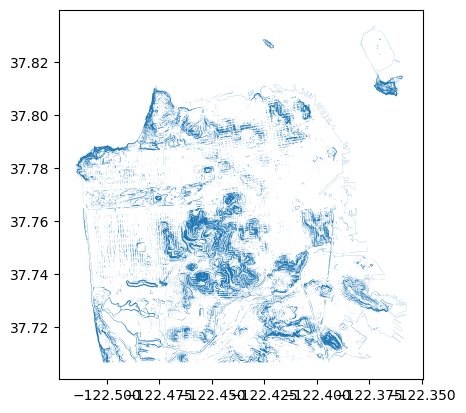

In [54]:
plt.clf()
slopes.plot()
plt.show()

In [55]:
full_df4_slopes = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='within')

In [56]:
full_df4_slopes.index_right.isna().mean().round(2)

0.99

In [57]:
full_df4_slopes2 = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='contains')

In [58]:
full_df4_slopes2.index_right.isna().mean().round(2)

0.97

In [59]:
full_df4_slopes = full_df4_slopes.rename({'index_right': 'steep_lot'}, axis=1)

In [60]:
full_df4_slopes2 = full_df4_slopes2.rename({'index_right': 'steep_lot'}, axis=1)

In [61]:
full_df4_slopes.steep_lot = full_df4_slopes.steep_lot.notna()

In [62]:
full_df4_slopes2.steep_lot = full_df4_slopes2.steep_lot.notna()

In [63]:
full_df4_slopes.steep_lot.mean()

0.014594919192710373

In [64]:
full_df4_slopes2.steep_lot.mean()

0.02778370893750283

In [65]:
full_df4_slopes2[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_slopes2[['CANTID_blklot_backup', 
                                                                                         'CANTID_geometry_backup']].astype(str)

In [67]:
full_df4_slopes2 = full_df4_slopes2.drop_duplicates()

In [68]:
full_df4_slopes2.shape

(153204, 68)

<Figure size 640x480 with 0 Axes>

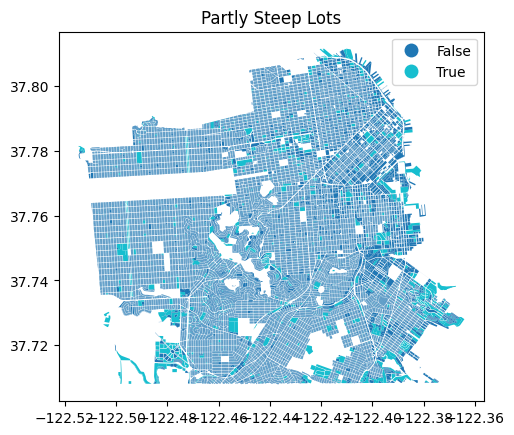

In [69]:
plt.clf()
full_df4_slopes2.plot(column='steep_lot', legend=True)
plt.title('Partly Steep Lots')
plt.show()

In [70]:
full_df4['entirely_steep_lot'] = full_df4_slopes.steep_lot

In [71]:
full_df4['partly_steep_lot'] = full_df4_slopes2.steep_lot

In [77]:
full_df4 = full_df4.reindex()

### Census Tracts

In [78]:
census.columns

Index(['age_18_21', 'age_22_29', 'age_30_39', 'age_40_49', 'age_50_64',
       'age_5_17', 'age_65_up', 'age_under5', 'ameri_es', 'asian',
       'ave_fam_sz', 'ave_hh_sz', 'black', 'county', 'families', 'females',
       'fhh_child', 'fipsstco', 'hawn_pi', 'hispanic', 'households',
       'hse_units', 'hsehld_1_f', 'hsehld_1_m', 'males', 'marhh_chd',
       'marhh_no_c', 'med_age', 'med_age_f', 'med_age_m', 'mhh_child',
       'mult_race', 'objectid', 'other', 'owner_occ', 'pop2000', 'renter_occ',
       'rural', 'state', 'stfid', 'tract', 'tractid', 'trt2000', 'urban',
       'vacant', 'white', 'geometry'],
      dtype='object')

In [79]:
full_df4_census = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                    census.to_crs('EPSG:26910'),
                                    how='left')

In [80]:
full_df4_census.shape

(153459, 116)

In [81]:
full_df4_census = full_df4_census.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])

In [82]:
full_df4_census.shape

(153204, 116)

In [88]:
full_df4_census.index.duplicated().sum()

3261

In [85]:
full_df4_census = full_df4_census.drop('index_right', axis=1)

In [86]:
full_df4 = full_df4_census

In [90]:
full_df4 = full_df4.reindex()

### Home Prices

#### Make Zillow data geospatial for a geospatial join

In [91]:
home_prices.RegionName = home_prices.RegionName.str.lower().str.split(' ').str.join('_')

In [92]:
sfneighborhoods.name = sfneighborhoods.name.str.lower().str.split(' ').str.join('_')

In [93]:
# I am replacing neighborhoods in Zillow data to match the sf open data neighborhood names.
neighborhood_map = {'mount_davidson_manor': 'mt._davidson_manor',
                    'haight': 'haight_ashbury',
                    'ingleside_terrace': 'ingleside_terraces',
                    'laurel_heights': 'laurel_heights_/_jordan_park',
                    'north_waterfront': 'northern_waterfront',
                    'marina_district': 'marina',
                    'ingleside_heights': 'merced_heights',
                    'lake': 'parkmerced'}

In [94]:
assert all([k in sfneighborhoods.name.values.tolist() for k in neighborhood_map.values()])
assert all([k in home_prices.RegionName.values.tolist() for k in neighborhood_map.keys()])

In [95]:
home_prices = home_prices.replace({'RegionName': neighborhood_map})

In [96]:
neighborhoods_hp = pd.merge(sfneighborhoods, home_prices, left_on='name', right_on='RegionName', how='right')

In [97]:
neighborhoods_hp = neighborhoods_hp.rename({'name': 'neighborhood', '2007-01-31': 'home_prices_jan07'}, axis=1)

In [98]:
full_df4 = full_df4.replace({'neighborhood': {'dowtown': 'downtown',
                                             'croker_amazon': 'crocker_amazon',
                                             'ingleside_terrace': 'ingleside_terraces',
                                             'sea_cliff': 'seacliff',
                                             'lake_shore': 'lakeshore'}})

In [99]:
# I am replacing neighborhoods in Zillow data to match the tax assessor neighborhood names.
# This may create mismatches between home_prices and sfneighborhoods but that's fine since that merge already happened
home_prices = home_prices.replace(
    {'RegionName' : {
        'buena_vista': 'buena_vista_park',
        'laurel_heights_/_jordan_park': 'jordan_park/laurel_heights', 
        'eureka_valley': 'eureka_valley/dolores_heights',
        'financial_district': 'financial_district_north',
        'civic_center': 'van_ness/_civic_center',
        'parnassus_heights': 'parnassus/ashbury_heights',
        'laguna_honda': 'forest_hill_extension',
        'mt._davidson_manor': 'mount_davidson_manor'
    }}
)

In [100]:
full_df4_hp = full_df4.merge(home_prices.add_prefix('hp_'),
                             left_on='neighborhood',
                             right_on='hp_RegionName',
                             how='left')

In [101]:
full_df4_hp = full_df4_hp.rename({'hp_2007-01-31': 'home_prices_jan07'}, axis=1)

In [118]:
full_df4_hp = full_df4_hp.drop('hp_RegionName', axis=1)

In [110]:
full_df4_hp = full_df4_hp.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])


In [111]:
full_df4_hp.home_prices_jan07.notna().mean()

0.7563183728884363

In [103]:
full_df4_hp2 = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                 neighborhoods_hp.drop('neighborhood', axis=1).to_crs('EPSG:26910'),
                                 how='left')

In [104]:
full_df4_hp2 = full_df4_hp2.drop(['RegionName', 'index_right'], axis=1)

In [105]:
full_df4_hp2[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_hp2[['CANTID_blklot_backup',
                                                                                 'CANTID_geometry_backup']].astype(str)

In [106]:
full_df4_hp2 = full_df4_hp2.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])


In [115]:
full_df4_hp.reindex()


In [135]:
full_df4_hp2 = full_df4_hp2.reset_index(drop=True)

In [136]:
full_df4_hp.home_prices_jan07 = full_df4_hp.home_prices_jan07.fillna(full_df4_hp2['home_prices_jan07'])

In [137]:
full_df4_hp.home_prices_jan07.notna().mean()

0.9999412547975248

In [138]:
full_df4 = full_df4_hp

<Figure size 640x480 with 0 Axes>

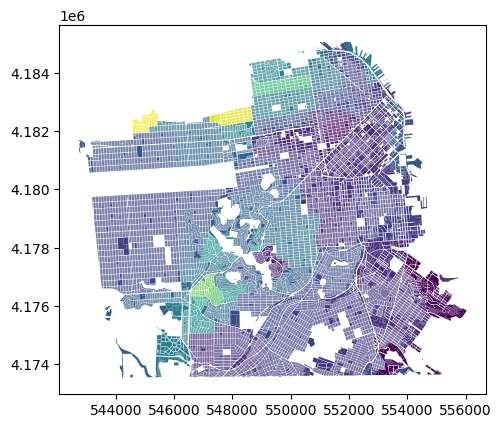

In [139]:
plt.clf()
full_df4.plot(column='home_prices_jan07')
plt.show()

### Treat inclusion in site inventory as a feature

In [140]:
full_df4 = clean_utils.get_site_inventory_feature(full_df4, sites, cycle=4)
full_df5 = clean_utils.get_site_inventory_feature(full_df5, sites, cycle=4)

### Drop constant columns

In [141]:
full_df4 = full_df4.drop([c for c in full_df4.columns if 'CANTID' in c], axis=1)
full_df5 = full_df5.drop([c for c in full_df5.columns if 'CANTID' in c], axis=1)

In [142]:
full_df4 = full_df4.drop(full_df4.columns[full_df4.nunique() <= 1], axis=1)
full_df5 = full_df5.drop(full_df5.columns[full_df5.nunique() <= 1], axis=1)

In [143]:
full_df4 = full_df4.drop(['geometry', 'blklot', 'mapblklot', 'active', 'PROPLOC', 'RP1PRCLID'], axis=1)

In [144]:
full_df5 = full_df5.drop(['geometry', 'blklot', 'mapblklot', 'active', 'PROPLOC', 'RP1PRCLID'], axis=1)

In [145]:
full_df4.to_csv('cleaned_rhna4_data.csv', index=False)
full_df5.to_csv('cleaned_rhna5_data.csv', index=False)